### Reproducing Fig.2 in Section 5 of Sánchez et. al

https://arxiv.org/abs/1807.11873

In [174]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [183]:
import scipy.stats
import pandas as pd
import time

In [176]:
## Initialize a seed to use throughout the notebook
seed = 123
rng = np.random.RandomState(seed)

#### 1. Draw a galaxy type for each galaxy from the following distribution:

<center>$ p(t) \propto t^{a} \exp{-(t/t_{0})^{a}}$</center>

with $a=1.5, \, t_{0}=0.3$.

First, we'll write a function to define this distribution:

In [177]:
def prob_type(t, a, t0):
    '''Distribution for galaxy of type t.
    
    Parameters
    ----------
    t : int or array
        Galaxy type(s) to be sampled.
    a : Model parameter.
    t0 : Model parameter.
    
    Returns
    -------
    int or array
    Distribution of probabilities.
    '''
    
    num = t ** a
    den = np.exp(t / t0) ** a
    
    p = num / den
    norm = np.sum(p)
    
    return(p / norm)

Let's see what this distribution looks like on a grid from 0 to 1:

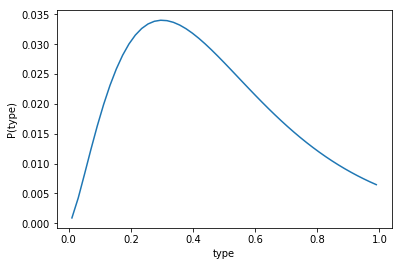

In [178]:
a = 1.5
t0 = 0.3

t_edge = np.linspace(0,1,50)
t_mid = 0.5 * (t_edge[1:] + t_edge[:-1])
p = prob_type(t_mid, a, t0)

plt.plot(t_mid, p)
plt.xlabel('type')
plt.ylabel('P(type)')
plt.show()

Next, we'll use inverse transform sampling to sample from this distribution (https://en.wikipedia.org/wiki/Inverse_transform_sampling)

We first generate the cumulative distribution function for this probability density and normalize it:

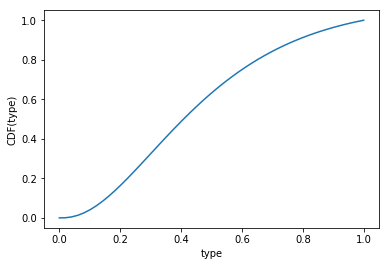

In [179]:
P = np.zeros_like(t_edge)
P[1:] = np.cumsum(p)
P /= P[-1] 

plt.plot(t_edge, P)
plt.xlabel('type')
plt.ylabel('CDF(type)')
plt.show()

In the paper, they generate 100,000 galaxies, so we will do that here. We are interested in calculating the inverse of the CDF. That is, we want to map a random number $u$ drawn from a uniform distribution to the minimum value $x$ in the domain such that:

<center>$ CDF(X \leq x) = u $</center>

We then do a search to find the index $i$ in the domain of the probability density function with value closest to $x$. The sampled value of the pdf is then $p(x_i)$.

In [180]:
N = 100000
u = rng.uniform(size=N)
## Interpolate the inverse of the CDF over u (types interpolated over u):
t = np.interp(u, P, t_edge)

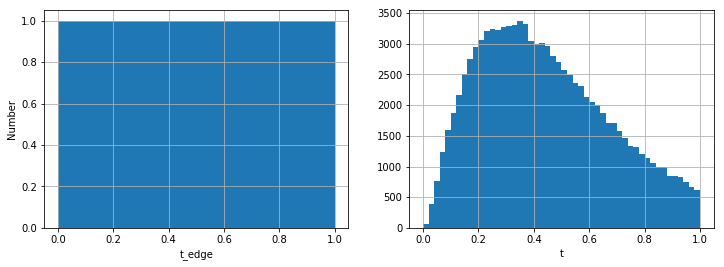

In [8]:
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(12,4))
ax1.hist(t_edge, bins=50)
ax2.hist(t, bins=50)
ax1.set_xlabel('t_edge')
ax1.set_ylabel('Number')
ax2.set_xlabel('t')
ax1.grid()
ax2.grid()
plt.show()

Now that we've generated the type distribution, we can randomly sample from it by generating random numbers and finding the value in the type distribution at the index where the difference between a randomly generated value and the uniform distribution (that was interpolated over to generate the type distribution) is minimized.

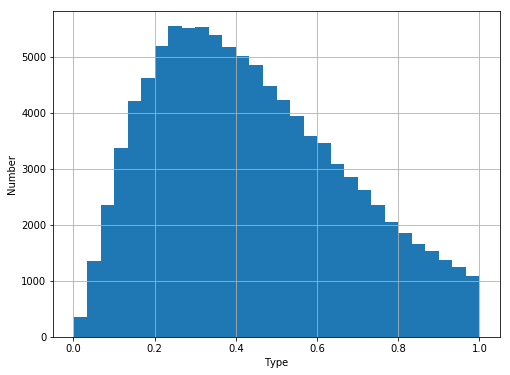

In [181]:
def sample(uniform_dist, type_dist, size):
    rndm = rng.uniform(size=size)
    idx = [(np.abs(uniform_dist - rndm[ii])).argmin() for ii in range(size)]
    return(type_dist[idx])

sampled_types = sample(u, t, N)

plt.figure(figsize=(8,6))
plt.hist(sampled_types, bins=30)
plt.xlabel('Type')
plt.ylabel('Number')
plt.grid()
plt.show()

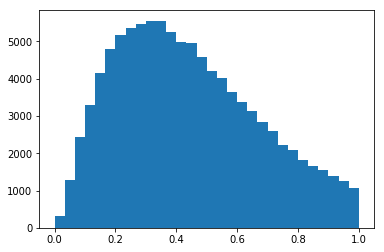

In [465]:
plt.hist(t, bins=30)
plt.show()

### Initialize pandas data frame

In [468]:
df = pd.DataFrame(columns=['F', 't', 'z', 'theta'])

In [469]:
## Store sampled types
df['t'] = sampled_types

#### 2. Assign redshifts based on type

In [190]:
def assign_redshifts(t):
    
    n = len(t)
    z = np.ones_like(t)
    
    rnd = rng.uniform(size=n)
    
    for ii, tt in enumerate(t):
        if tt == 0:
            if rnd[ii] >= 0.2:
                z[ii] = tt
            else:
                z[ii] = tt + 0.02
        if tt == 1:
            if rnd[ii] >= 0.2:
                z[ii] = tt
            else:
                z[ii] = tt - 0.02
        else:
            if rnd[ii] >= 0.4:
                z[ii] = tt
            if tt < 0.02:
                z[ii] = tt + 0.02
            elif tt > 0.98:
                z[ii] = tt - 0.02
            else:
                if (rnd[ii] >= 0.2) and (rnd[ii] < 0.4):
                    z[ii] = tt + 0.02
                else:
                    z[ii] = tt - 0.02   
    return(z)

In [191]:
z = assign_redshifts(sampled_types)
print(np.min(z), np.max(z))

0.00017089092978053722 0.9999335046937761


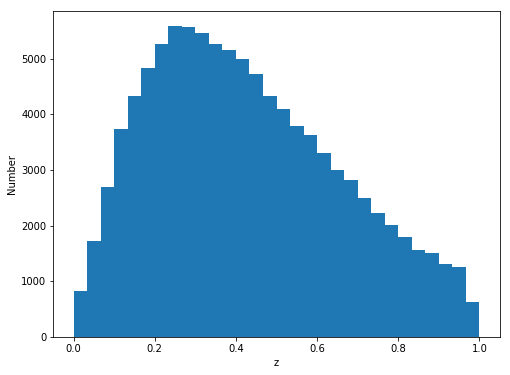

In [192]:
plt.figure(figsize=(8,6))
plt.hist(z, bins=30)
plt.xlabel('z')
plt.ylabel('Number')
plt.show()
plt.show()

In [470]:
## Store redshifts
df['z'] = z

#### 3. Define a Gaussian likelihood for the features given type

In [201]:
sig_F = 0.2
def feature_likelihood(t, sig_F=sig_F):
    return(scipy.stats.norm.rvs(loc=sampled_types, random_state=rng))

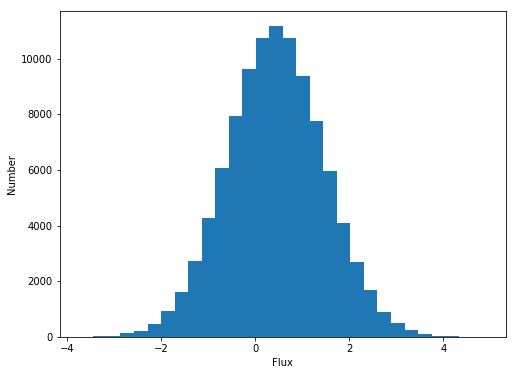

In [202]:
features = feature_likelihood(sampled_types)

plt.figure(figsize=(8,6))
plt.hist(fluxes, bins=30)
plt.xlabel('Flux')
plt.ylabel('Number')
plt.show()

In [471]:
df['F'] = features

#### 4. Draw a position based on each galaxy redshift
<center>$ p(\theta | z) \propto (1 + \delta (\theta, z))$</center>

#### Generate a Gaussian Random Field (GRF):

- For each redshift bin (or slice) we generate δz from a Gaussian Random Field (GRF) with a resolution of 1024x1024 pixels that we will use to define galaxy positions in a way to simulate galaxy clustering.

In [205]:
def fftIndgen(n):
    a = range(0, int(n/2)+1)
    b = range(1, int(n/2))
    b = reversed(b)
    a = [i for i in a]
    b = [-i for i in b]
    return a + b

def gaussian_random_field(Pk = lambda k : k**-3.0, size = 100):
    def Pk2(kx, ky):
        if kx == 0 and ky == 0:
            return 0.0
        return np.sqrt(Pk(np.sqrt(kx**2 + ky**2)))
    noise = np.fft.fft2(np.random.normal(size = (size, size)))
    amplitude = np.zeros((size,size))
    for i, kx in enumerate(fftIndgen(size)):
        for j, ky in enumerate(fftIndgen(size)):            
            amplitude[i, j] = Pk2(kx, ky)
    return np.fft.ifft2(noise * amplitude)

## Generate delta field
nx = 1024
ny = 1024
nz = 50

delta = np.empty((nx,ny,nz))
alpha = -3.0

for i in range(50):
    delta[:,:,i] = gaussian_random_field(Pk = lambda k: k**alpha, size=nx).real
    ## Each data slice is to have std = 2.5
    z_slice = delta[:,:,i]
    delta[:,:,i] = (z_slice / np.std(z_slice)) * 2.5

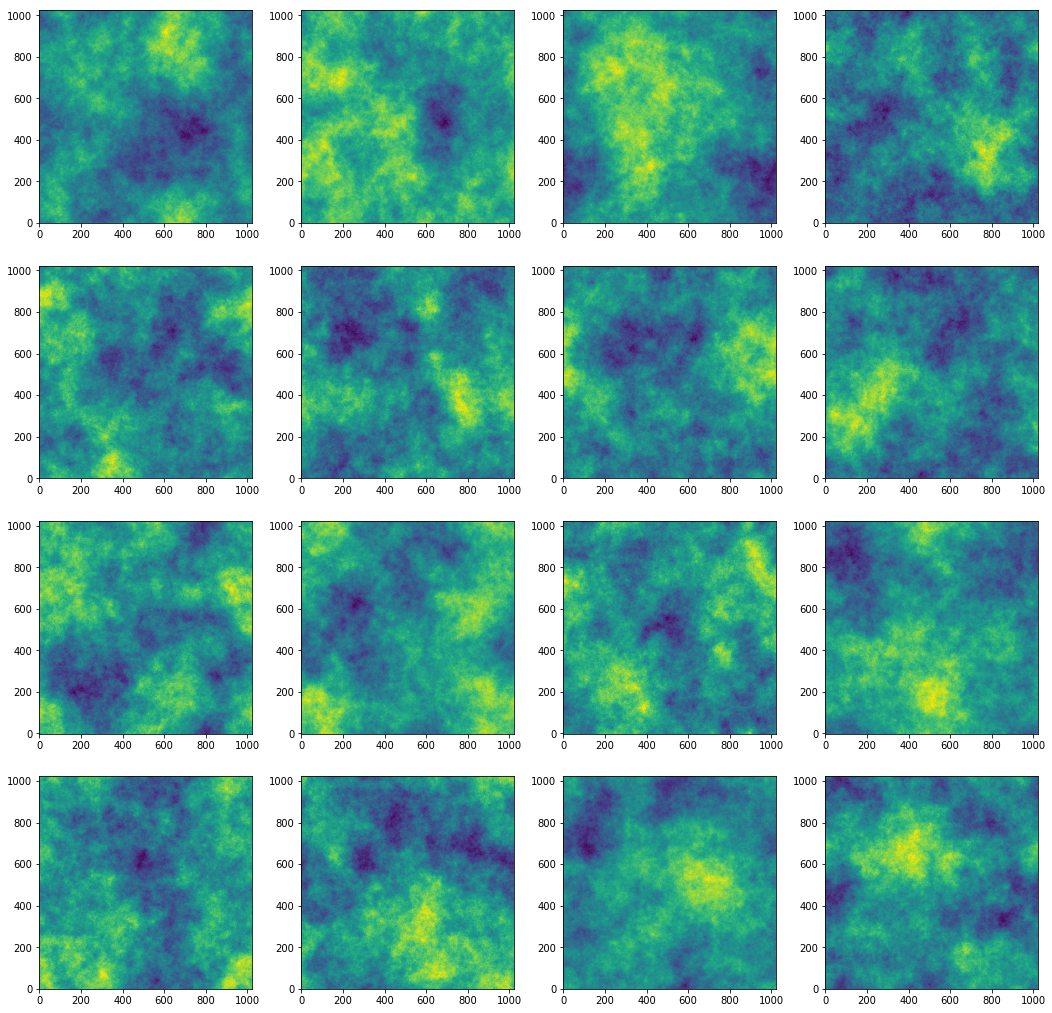

In [206]:
fig, axs = plt.subplots(4,4, figsize=(18,18))
axs = axs.ravel()

for i in range(16):
    axs[i].imshow(delta[:,:,i], interpolation='none', origin='lower')
plt.show()

1) why does taking the standard deviation of the data / std dev give you 1?

2) how come if we don't do 1), we don't get non-negative values in the histogram below?

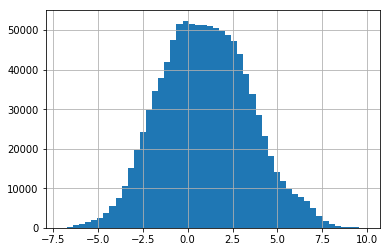

In [207]:
## Let's look at the first slice
plt.hist(delta[:,:,0].flatten() + 1, bins=50)
plt.grid()
plt.show()

From Eq. 37, we want to sample theta from the density field rho (delta + 1):

In [208]:
## Clip to get non-negative density field
rho = np.maximum(0, delta + 1)

In [ ]:
### Find a way to speed this up...

100000


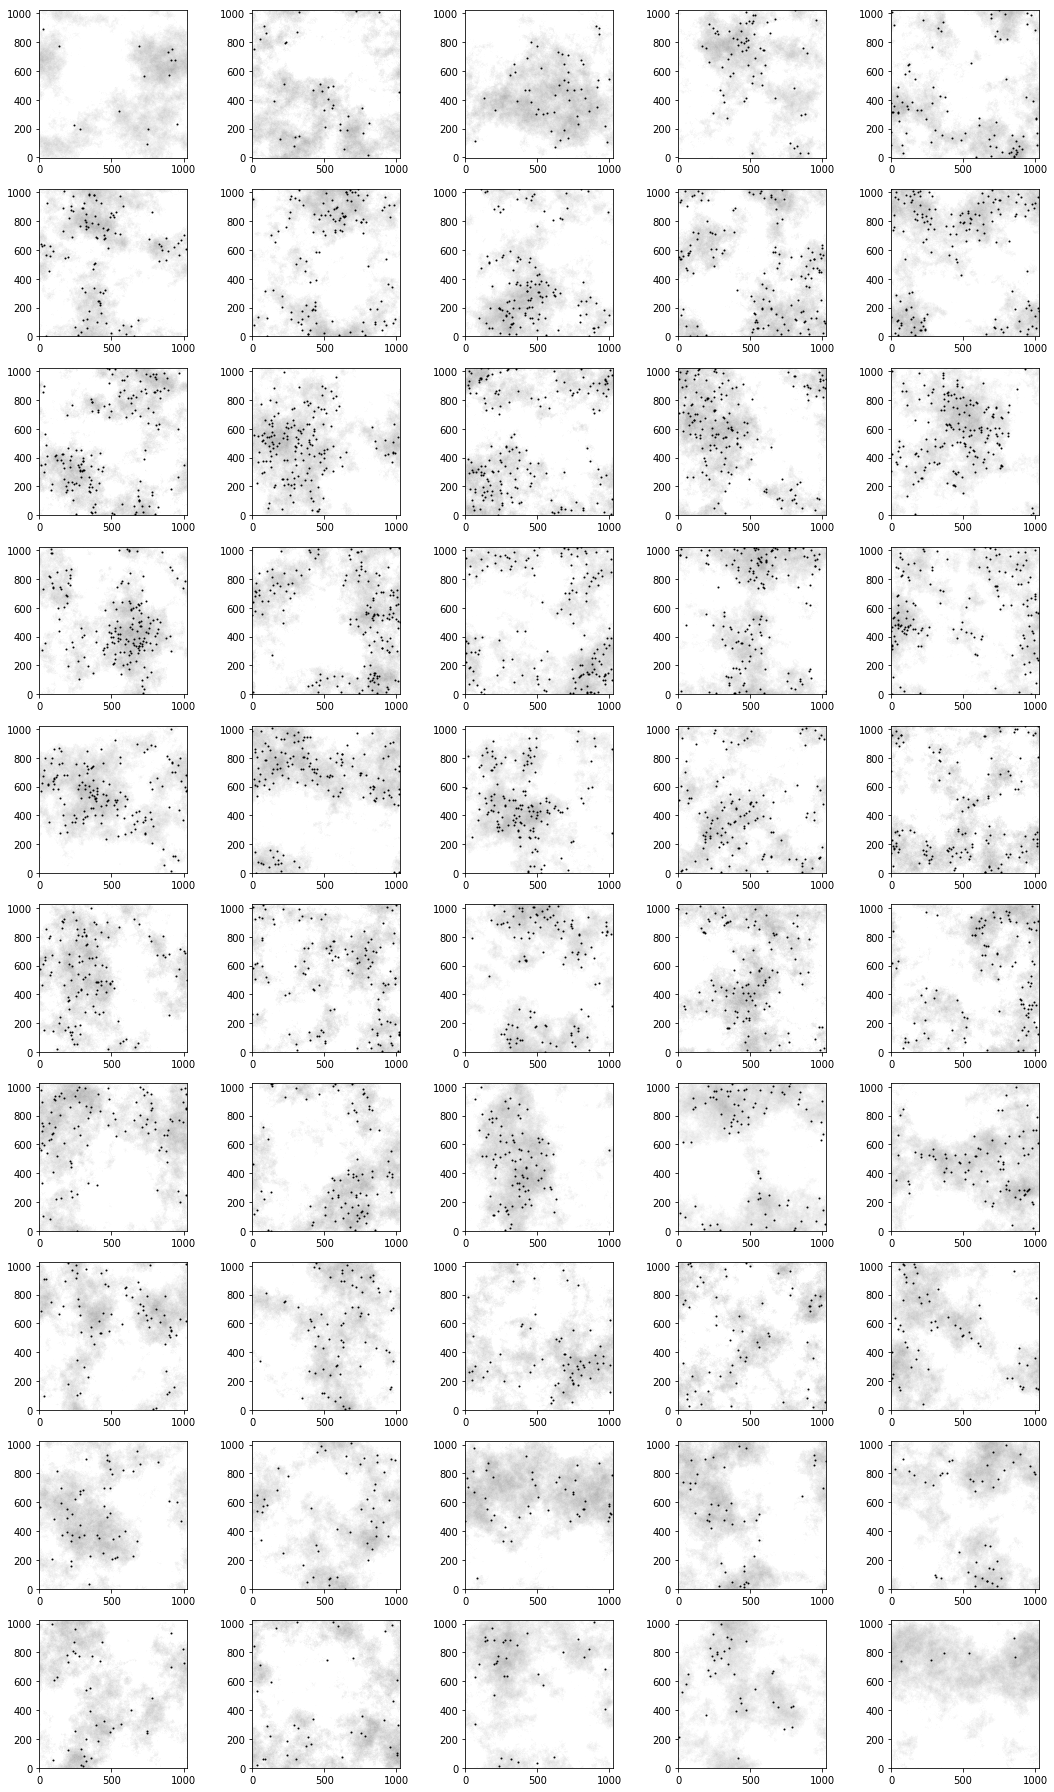

In [418]:
fig, axs = plt.subplots(10,5, figsize=(15,25))
axs = axs.ravel()

z_bins = np.linspace(0, 1, num=nz + 1)
z_indices = np.digitize(z, z_bins)
n_slices = nz
n_theta = nx * ny
edges = np.arange(0, nx * ny + 1)

thetas = pd.DataFrame(columns=['z_bin', 'theta'])

## Am I plotting at edges or bin centers? Make sure it's at centers...

for i in range(n_slices):
    z_slice = rho[:,:,i]
    cdf = np.zeros_like(edges)
    cdf[1:] = np.cumsum(z_slice)
    cdf = cdf / cdf[-1]
    u = rng.randint(0, n_theta + 1, size=n_theta) / n_theta
    theta = np.interp(u, cdf, edges)
    ## Count the number of galaxies that fall into each redshift bin
    n_per_z_bin = np.count_nonzero(z_indices == i+1)
    ## Store positions of all galaxies in bin
    sampled_positions = sample(u, theta, n_per_z_bin)
    d = {'z_bin': int(i), 'theta': sampled_positions.astype(int)}
    positions = pd.DataFrame(data = d)
    thetas = thetas.append(positions)
    ## Only plot a 5% random subset of galaxies that fall into each bin
    n_samples = int(n_per_z_bin * 0.05)
    sub_sampled_positions = sample(u, theta, n_samples)
    indices = sub_sampled_positions.astype(int)
    grid = np.arange(nx * ny).reshape(nx, ny)
    x = np.zeros(n_samples)
    y = np.copy(x)
    for j in range(n_samples):
        pos = np.argwhere(grid == indices[j])
        try:
            x[j] = pos[0][0]
        except IndexError: 
            pass
        try:
            y[j] = pos[0][1]
        except IndexError:
            pass
    axs[i].imshow(z_slice.T, origin='lower', cmap='gray_r', alpha=0.3)
    axs[i].plot(x, y, '.', c='k', ms=2)
plt.tight_layout()
plt.show()

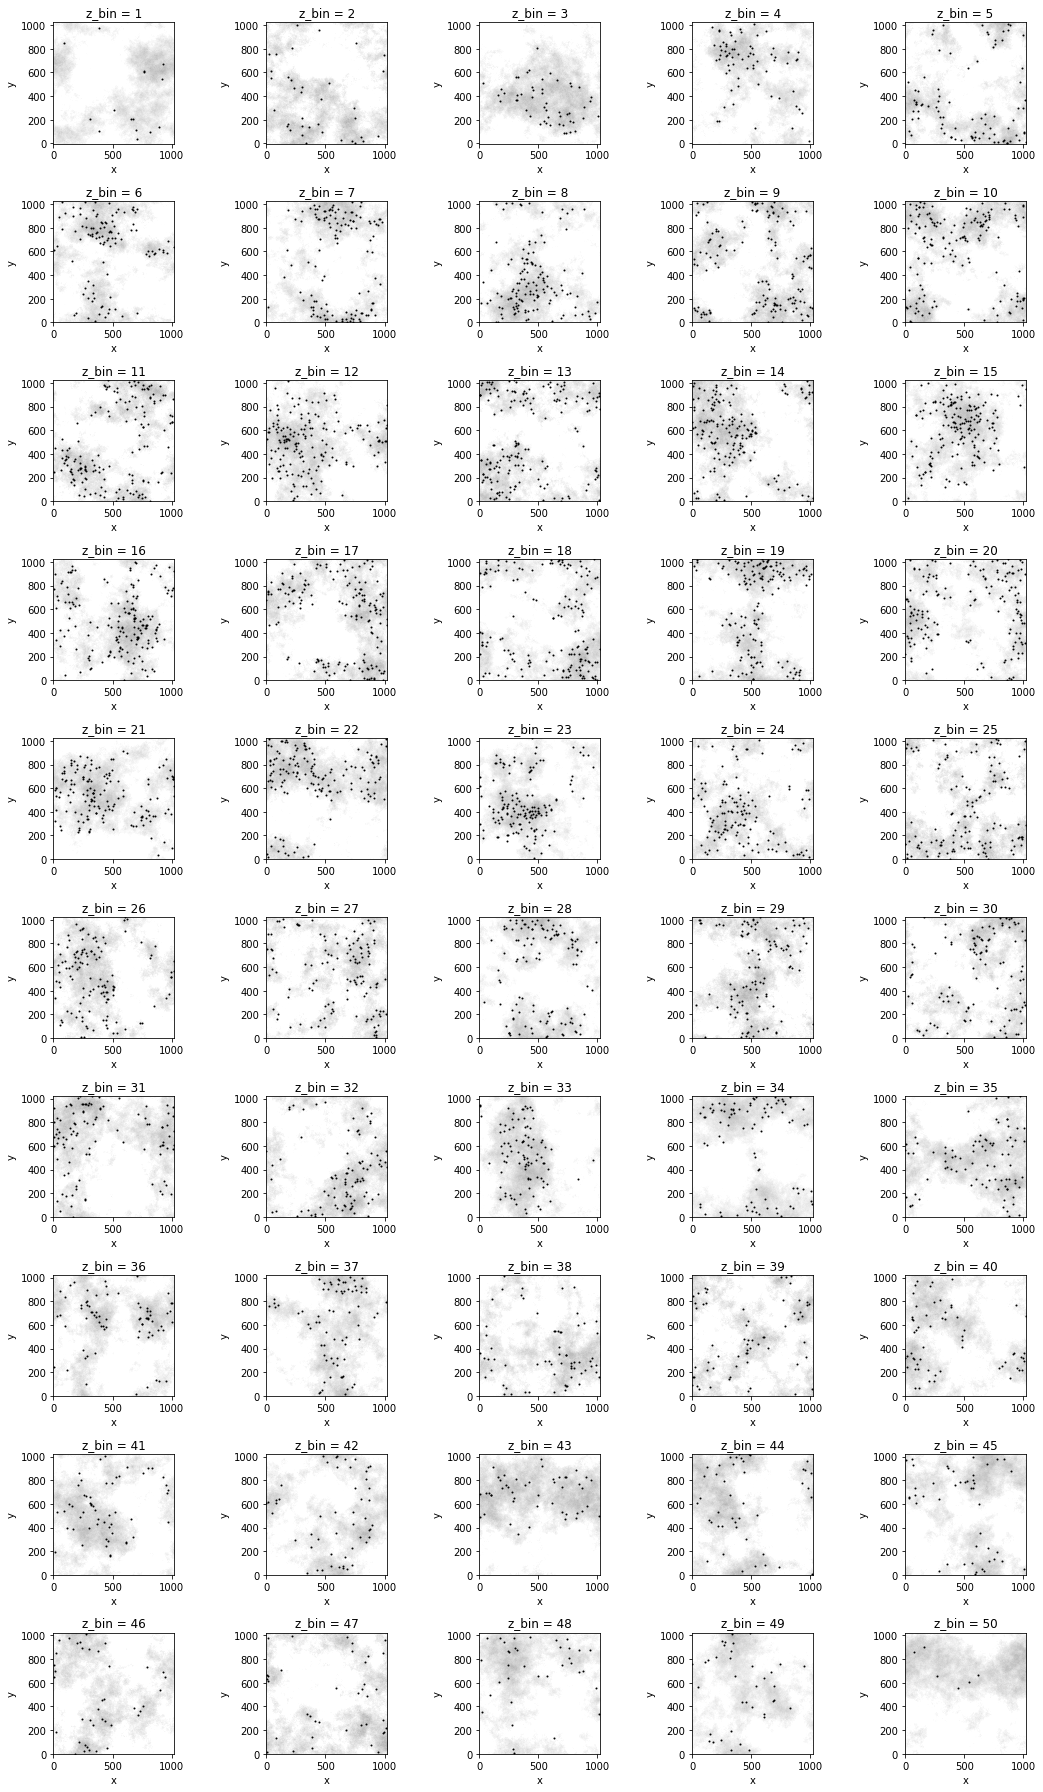

In [591]:
fig, axs = plt.subplots(10,5, figsize=(15,25))
axs = axs.ravel()

z_bins = np.linspace(0, 1, num=nz + 1)
z_indices = np.digitize(z, z_bins)
n_slices = nz
n_theta = nx * ny
edges = np.arange(0, nx * ny + 1)

thetas = pd.DataFrame(columns=['z_bin', 'theta'])

## Am I plotting at edges or bin centers? Make sure it's at centers...

for i in range(n_slices):
    z_slice = rho[:,:,i]
    cdf = np.zeros_like(edges)
    cdf[1:] = np.cumsum(z_slice)
    cdf = cdf / cdf[-1]
    u = rng.randint(0, n_theta + 1, size=n_theta) / n_theta
    theta = np.interp(u, cdf, edges)
    ## Count the number of galaxies that fall into each redshift bin
    n_per_z_bin = np.count_nonzero(z_indices == i+1)
    ## Store positions of all galaxies in bin
    sampled_positions = sample(u, theta, n_per_z_bin)
    d = {'z_bin': int(i), 'theta': sampled_positions.astype(int)}
    positions = pd.DataFrame(data = d)
    thetas = thetas.append(positions)
    ## Only plot a 5% random subset of galaxies that fall into each bin
    n_samples = int(n_per_z_bin * 0.05)
    sub_sampled_positions = sample(u, theta, n_samples)
    indices = sub_sampled_positions.astype(int)
    grid = np.arange(nx * ny).reshape(nx, ny)
    x = np.zeros(n_samples)
    y = np.copy(x)
    for j in range(n_samples):
        pos = np.argwhere(grid == indices[j])
        try:
            x[j] = pos[0][0]
        except IndexError: 
            pass
        try:
            y[j] = pos[0][1]
        except IndexError:
            pass
    axs[i].imshow(z_slice.T, origin='lower', cmap='gray_r', alpha=0.3)
    axs[i].plot(x, y, '.', c='k', ms=2)
    axs[i].set_xlabel('x')
    axs[i].set_ylabel('y')
    axs[i].set_title('z_bin = {}'.format(i+1))
plt.tight_layout()
plt.savefig('density_field.png')
plt.show()

In [422]:
grid = np.arange(n_theta).reshape(nx,ny)

In [424]:
## store this in cell above where we generate density plots

all_bin_counts = np.empty(nz)

for i in range(nz):
    all_bin_counts[i] = np.count_nonzero(z_indices == i+1)

In [483]:
## k index goes from 0 to 99999 to loop through all elements in df, where j indexes 'thetas' which starts
## counting from zero each time it reaches the next z_bin
k = 0
for i in range(nz):
    ## identify galaxies that fall in bin i and get index (on a 1024 x 1024 grid) for galaxy j in this bin
    gals_in_bin_i = thetas['theta'][thetas['z_bin'] == i]
    for j in range(int(all_bin_counts[i])):
        ## find (x,y) coordinates on grid where index in grid equals index in jth galaxy in gals_in_bin_i
        position = np.argwhere(grid == gals_in_bin_i[j])
        ## add this to index j in bin i of 'theta' column data frame
        df.set_value(k, 'theta', position[0])
        k += 1                               
        #position = np.argwhere(grid == thetas['theta'][thetas['z_bin'] == i][j])
        #df.set_value(k, 'theta', position[0])
        #k += 1

In [427]:
df.to_pickle('galaxy_data.pkl')

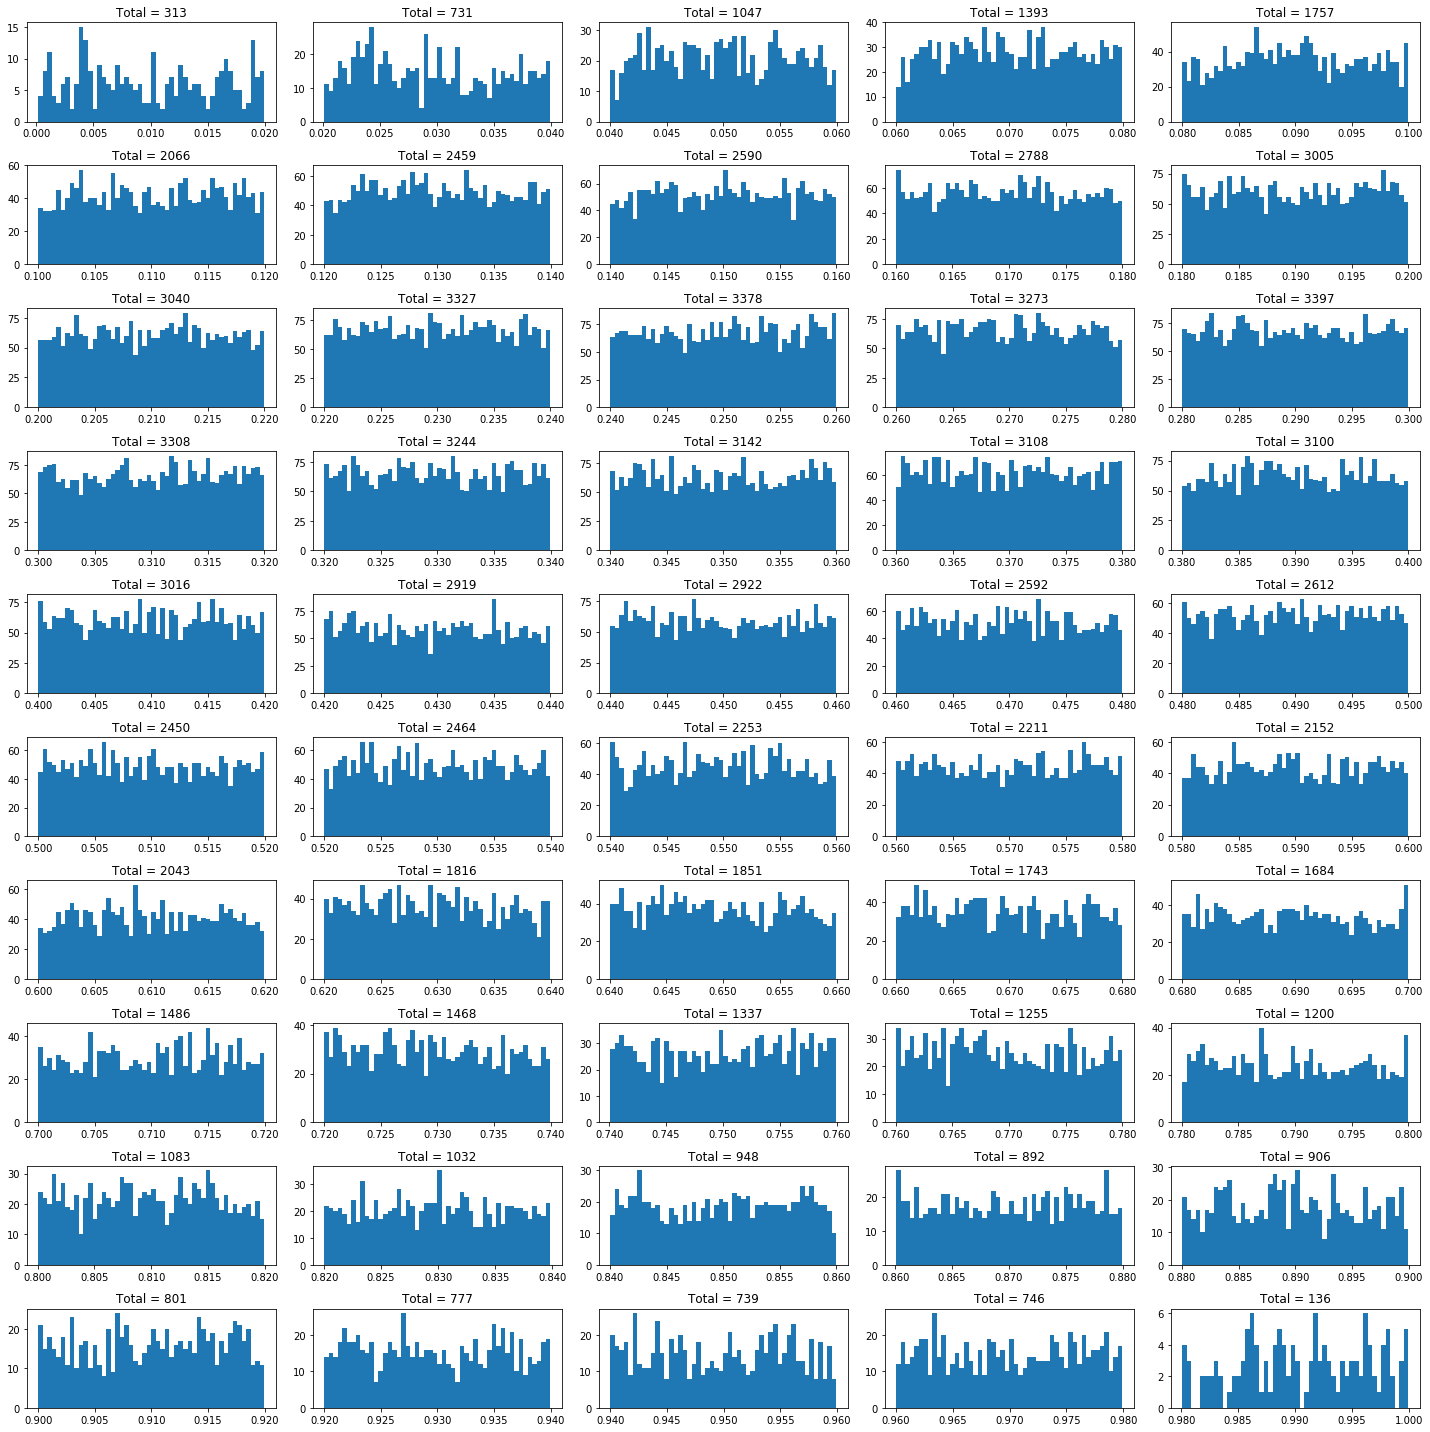

In [247]:
fig, axs = plt.subplots(10,5, figsize=(20,20))
axs = axs.ravel()

total = 0

for idx in range(n_slices):
    select_bin = z_indices == idx + 1
    axs[idx].hist(z[select_bin], bins=nz)
    axs[idx].set_title('Total = {}'.format(np.count_nonzero(select_bin)))
    total += np.count_nonzero(select_bin)
plt.tight_layout()
plt.show()

In [24]:
N * np.sum(rho.sum(axis=(0,1)) / rho.sum())

99999.9999999999

### Apply sampling methods outlined in Section IV

1) Make a 2D histogram in redshift-type space and count the number of galaxies in each bin.

2) Generate Dirichlet prior on $f$, the set of all joint redshift-type probabilities $f_{zt}$ for all types and redshifts. The Dirichlet prior, $p(f)$, has the following distribution: 

$f(x_{1}, ..., x_{K}; \alpha_{1}, ..., \alpha_{K}) = \frac{1}{B(\vec{\alpha}) \prod_{i=1}^{K}x_{i}^{\alpha_{i}-1}$

We know $\alpha_{i}-1$, which is $N_{zt} + 1$, and we know $x_{i}$, which is $f_{i}$, or the fraction of galaxies in each reshift-type bin with respect to the total number of galaxies. The Beta function is also easily calculated from the $N_{zt}$ for each bin:
$$
B(\vec{\alpha}) = \prod_{i=1}^{K} \frac{\Gamma(\alpha_{i})}{\Gamma(\Sigma_{i=1}^{K}\alpha_{i})} \;
$$
3) 

In [794]:
## Create 2D histogram in type and redshift
nt = nz
t_bins = np.linspace(0, 1, nt+1)
t_mdpt = (t_bins[1:] + t_bins[:-1]) / 2
z_mdpt = (z_bins[1:] + z_bins[:-1]) / 2
h, edges = np.histogramdd([df['z'], df['t']], bins=(z_bins, t_bins))

In [795]:
h.shape

(50, 50)

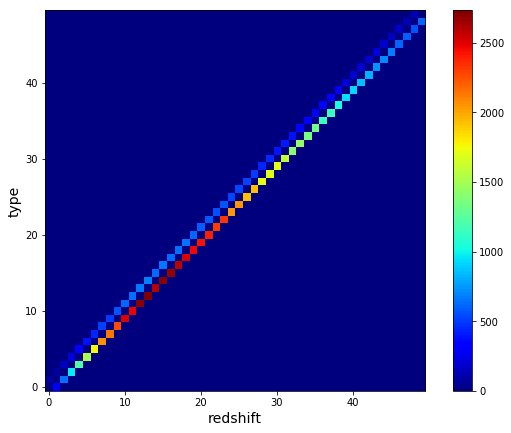

In [19]:
plt.figure(figsize=(10,7))
plt.imshow(h, cmap='jet', origin='lower', interpolation='none')
plt.xlabel('redshift', fontsize=14)
plt.ylabel('type', fontsize=14)
plt.colorbar()
plt.show()

This distribution makes sense, since type is assigned based on a piecewise function in terms of redshift, where type is $z \pm 0.02$.

In [796]:
## h is a proxy for Nzt
alpha = h.flatten() + 1
## calculate fraction of galaxies in each bin (the probability of finding a galaxy in that bin)
f = (h / np.sum(h)).flatten()

In [797]:
## Should equal total number of galaxies
np.sum(h)

100000.0

In [798]:
## Are conditions on the prior satisfied?
np.sum(f), np.min(f), np.max(f)
#np.sum(diri, axis=1), np.mean(diri, axis=0)

(1.0, 0.0, 0.02732)

In [799]:
## Initialize conditional dirichlet posterior on the fractions/probabilities for all z slices
diri = scipy.stats.dirichlet.rvs(alpha, random_state=rng, size=1)

In [800]:
dirichlet = diri.reshape(nz,nt)

In [801]:
probs = np.empty((nz,nt)) #redshift, type

start = time.time()
for k in range(100): # N -- find shortcut to extend to all 100K galaxies
    norm = scipy.stats.norm.pdf(t_mdpt, loc=df['F'][k], scale=sig_F) ## N(i - F_k | sig_F**2)
    probs = dirichlet * norm * rho[df['theta'][k][0], df['theta'][k][1]].reshape(-1,1)
                
print(time.time() - start)

0.024376869201660156


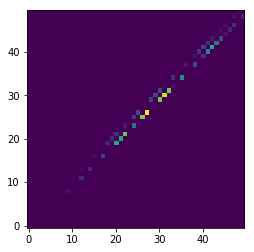

In [804]:
plt.imshow(probs, origin='lower')
plt.show()

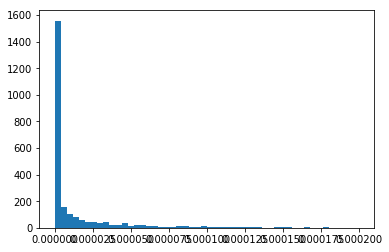

In [805]:
plt.hist(probs.flatten(), bins=50, range=(0,0.0002))
plt.show()

In [806]:
cdf = np.cumsum(probs.flatten()) ## is it ok that first element in cumulative sum isn't zero?
cdf /= cdf[-1]

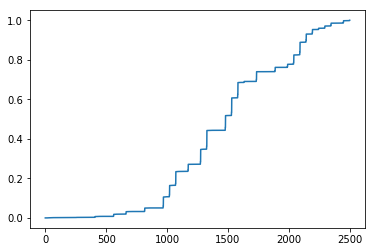

In [807]:
plt.plot(cdf)

In [813]:
u = rng.uniform()
idx = np.argmin(np.abs(cdf - u))
it = idx % nt
iz = idx // nt
print(idx == iz * nt + it)

True


In [814]:
it, iz

(35, 34)

In [815]:
probs.flatten()[idx], probs[iz, it]

(0.060778373678379786, 0.060778373678379786)

In [816]:
t_mdpt[it], z_mdpt[iz]

(0.71, 0.6900000000000001)

In [ ]:
## sample 100k galaxies from this cdf (each index on x-axis is a combination of ij (type and redshift))
## compare z and t distributions to original z and t distributions

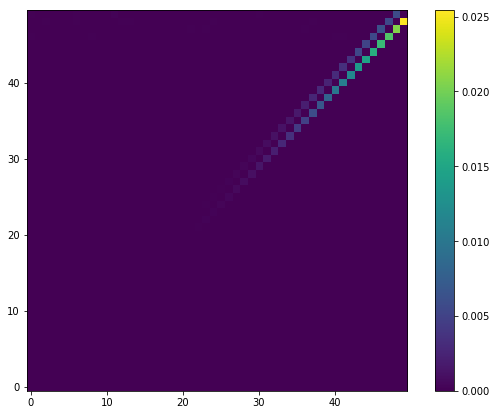

In [568]:
plt.figure(figsize=(10,7))
plt.imshow(probs, origin='lower')
plt.colorbar()
plt.show()

In [570]:
np.sum(probs)

0.2845162540814539

In [ ]:
## now sample from this 2d histogram?

We now have a sample of $\vec{f}$, the set of all joint probability distributions of type and redshift. It contains a sample distribution of $f_{tz}$, one for each combination of type and redshift (50 x 50). This is the input to the second stage of the Gibbs sampler, where the posterior in Eq. 27 is calculated for each galaxy.

In [27]:
diri = diri.flatten()
x = linspace(0,1,len(diri)+1)
x_mdpt = (x[:-1] + x[1:]) / 2

In [63]:
cdf = np.zeros_like(x)
cdf = np.cumsum(diri)
cdf = cdf / cdf[-1]

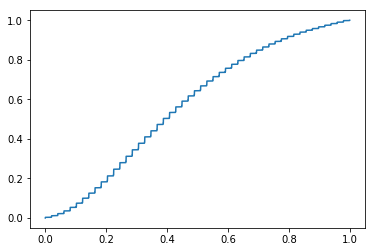

In [65]:
plt.plot(x_mdpt, cdf)
plt.show()

In [78]:
nt = 50
nz = 50
nf = nt * nz
u = rng.uniform(size=nf)
## Interpolate the inverse of the CDF (x) over u (fractions interpolated over u):
f = np.interp(u, cdf, x_mdpt)

In [79]:
sampled_diri = sample(u, f, nf)

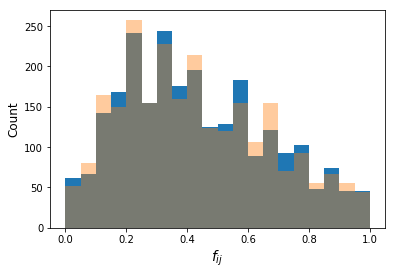

In [80]:
plt.hist(sampled_diri, bins=20)
plt.hist(f, bins=20, alpha=0.4)
plt.xlabel(r'$f_{ij}$', fontsize=14)
plt.ylabel('Count', fontsize=12)
plt.show()

In [162]:
dirichlet = diri.reshape(nt,nz)

probs = np.empty((nz,nz))

for k in range(5): # N
    for i in range(nz): # nt
        norm = scipy.stats.norm.pdf(t_mdpt[i], loc=fluxes[k], scale=sig_F) ## N(i - F_k | sig_F**2)
        for j in range(nz): # nz
            d_ij = dirichlet[i,j] ## f_ij
            indices_list[j]
            probs[i,j] = d_ij * norm

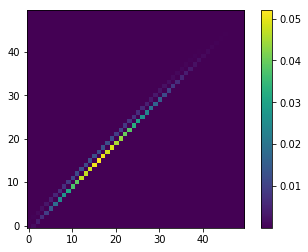

In [163]:
plt.imshow(probs, origin='lower')
plt.colorbar()
plt.show()

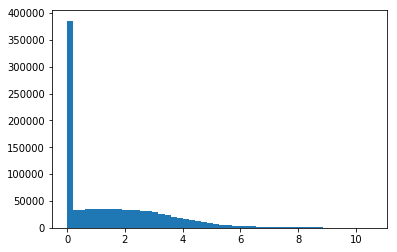

In [129]:
plt.hist(rho[:,:,0].flatten(), bins=50)
plt.show()

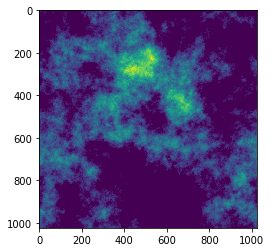

In [130]:
plt.imshow(rho[:,:,0])

In [132]:
np.count_nonzero(rho[:,:,0].flatten() == 0)

354090

In [133]:
len(rho[:,:,0].flatten())

1048576

In [134]:
354090 / 1048576

0.33768653869628906

##or...is this the right way to do it?
def sample_cdf(pdf, cdf, size):
    u = rng.uniform(size=size)
    indices = [np.argmin(np.abs(u[ii] - cdf)) for ii in range(size)]
    return(pdf[indices])